In [1]:
from datasets import load_dataset
import os
from hazm import stopwords_list
import re
from hazm import word_tokenize
from hazm import Normalizer , Stemmer , WordTokenizer , Lemmatizer , stopwords_list
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report , ConfusionMatrixDisplay , confusion_matrix , accuracy_score , recall_score , precision_score , roc_curve , auc , f1_score , roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [2]:
# Load SnappFood dataset from Hugging Face
dataset = load_dataset("ParsiAI/snappfood-sentiment-analysis")

# Convert splits to pandas DataFrames
train_df = dataset["train"].to_pandas()
valid_df = dataset["validation"].to_pandas()
test_df = dataset["test"].to_pandas()

# Save each as CSV
folder_name = "data/raw"

if not os.path.exists(folder_name):
    os.makedirs(folder_name)
    print("Folder created.")

    train_df.to_csv(f"{folder_name}/snappfood_train.csv", index=False, encoding="utf-8")
    valid_df.to_csv(f"{folder_name}/snappfood_validation.csv", index=False, encoding="utf-8")
    test_df.to_csv(f"{folder_name}/snappfood_test.csv", index=False, encoding="utf-8")

else:
    print("Folder already exists.")

print("CSV files successfully saved!")

Folder already exists.
CSV files successfully saved!


In [3]:
train_df.head()

,comment,label,label_id
0,غذا خیلی سرد بود در صورتیکه فاصله ما خیلی کم است,SAD,1.0
1,بهتره بتونیم ران یا سینه رو خودمون انتخاب کنیم,HAPPY,0.0
2,غذا بد بود حالم خیییییلی بده. دل دردو دل پیچه....,SAD,1.0
3,با سلام سابق بر این بسته بندی از کیفیت بهتری ب...,SAD,1.0
4,سلام، خیلی ممنون و متشکرم,HAPPY,0.0


In [4]:
valid_df.head(2)

,comment,label,label_id
0,درسته که توی فودپارتی راضی شدید تخفیف بیشتری ب...,SAD,1.0
1,سلام تخم مرغ را برندی دیگه فرستادن قرار شدن عو...,SAD,1.0


In [5]:
test_df.tail(2)

,comment,label,label_id
9031,غذای خوبی بود نسبت به قیمتش,HAPPY,0.0
9032,تمام شیرینی‌ها خرد شده بود,SAD,1.0


In [6]:
stopwords = {
"و","در","به","از","که","با","است","را","برای","این","آن","تا","یا","اما","اگر","هر","یک","هم","همان","خود",
"شود","شده","شوند","کرد","کردن","می","های","هایش","آنها","ما","شما","او","من","تو","چرا","چگونه","چه",
"کجا","کی","یا","همچنین","بسیار","زیاد","کم","دیگر","نیز","بی","هیچ","پس","قبل","بعد","چون","نه","آیا",
"بود","باشد","باشند","نیست","نیستند","هست","هستند","باشد","داشت","دارم","دارید","دارند",
"مگر","حتی","بین","توسط","روی","تحت","بدون","مثل","مانند","اما","بلکه","زیرا","چنانچه"
}

normalize = Normalizer()
stemmer = Stemmer()
lemmatizer = Lemmatizer()
tokenizer = WordTokenizer()


def preprocess(text , stem_ok = True , lemat_ok = True):
    text = normalize.normalize(text)

    text = re.sub(r"http\S+|www\S+|@\S+|#\S+", "", text)
    text = re.sub(r"[^\w\s\u263a-\U0001f999]", " ", text)
    text = re.sub(r"\d+", "", text)

    token = tokenizer.tokenize(text)

    token = [word for word in token if word not in stopwords]
    if stem_ok:
        token = [stemmer.stem(word) for word in token]
    elif lemat_ok:
        token = [lemmatizer.lemmatize(word) for word in token]
    return ' '.join(token)

In [7]:
sample = "غذااااا خیلی دیر رسید ولی خوشمزه بود 😍🔥"
print(preprocess(sample , stem_ok=True , lemat_ok=False))

غذا خیل دیر رسید ول خوشمزه 😍🔥


In [8]:
sample = "غذااااا خیلی دیر رسید ولی خوشمزه بود 😍🔥"
print(preprocess(sample , lemat_ok=True , stem_ok=False))

غذا خیلی دیر رسید ولی خوشمزه 😍🔥


In [9]:
def apply_preprocess(row):
    row["clean_text"] = preprocess(row["comment"] , lemat_ok=True   , stem_ok=False)
    return row


train_df["clean_text"] = train_df["comment"].apply(preprocess)
valid_df["clean_text"] = valid_df["comment"].apply(preprocess)
test_df["clean_text"] = test_df["comment"].apply(preprocess)

In [10]:
train_df.iloc[122]

comment       کیفیت برنج خوب بود ولی کیفیت جوجه واقعا بد بود...
label                                                       SAD
label_id                                                    1.0
clean_text    کیف برنج خوب ول کیف جوجه واقعا بد انقد سف اصلا...
Name: 122, dtype: object

In [11]:
def create_vectorizer(train_df, valid_df, text_col="clean_text", max_features=30000, ngram=(1,2)):
    """
    train_df, valid_df: DataFrames containing text and labels
    text_col: clean text column name
    max_features: TF-IDF max vocabulary size
    ngram: tuple to define n-gram range (default bigram)
    """

    vectorizer = TfidfVectorizer(max_features=max_features, ngram_range=ngram)

    # Fit on training and transform both
    X_train = vectorizer.fit_transform(train_df[text_col])
    X_valid = vectorizer.transform(valid_df[text_col])

    return vectorizer, X_train, X_valid

In [12]:
def train_model(model , X_train , y_train):
    model.fit(X_train , y_train)
    return model

In [13]:
def evaluate_with_threshold(model, X_train, y_train, X_val, y_val, X_test, y_test,
                            threshold=0.5, save_csv=True, filename="evaluation_results.csv"):

    results = {}

    # TRAIN
    y_prob_train = model.predict_proba(X_train)[:, 1]
    y_pred_train = (y_prob_train > threshold).astype(int)

    results["train_accuracy"] = accuracy_score(y_train, y_pred_train)
    results["train_precision"] = precision_score(y_train, y_pred_train)
    results["train_recall"] = recall_score(y_train, y_pred_train)
    results["train_f1"] = f1_score(y_train, y_pred_train)
    results["train_auc"] = roc_auc_score(y_train, y_prob_train)

    # VALIDATION
    y_prob_val = model.predict_proba(X_val)[:, 1]
    y_pred_val = (y_prob_val > threshold).astype(int)

    results["val_accuracy"] = accuracy_score(y_val, y_pred_val)
    results["val_precision"] = precision_score(y_val, y_pred_val)
    results["val_recall"] = recall_score(y_val, y_pred_val)
    results["val_f1"] = f1_score(y_val, y_pred_val)
    results["val_auc"] = roc_auc_score(y_val, y_prob_val)

    # TEST
    y_prob_test = model.predict_proba(X_test)[:, 1]
    y_pred_test = (y_prob_test > threshold).astype(int)

    results["test_accuracy"] = accuracy_score(y_test, y_pred_test)
    results["test_precision"] = precision_score(y_test, y_pred_test)
    results["test_recall"] = recall_score(y_test, y_pred_test)
    results["test_f1"] = f1_score(y_test, y_pred_test)
    results["test_auc"] = roc_auc_score(y_test, y_prob_test)

    # Convert to DataFrame
    df_results = pd.DataFrame([results])

    # Save results if needed
    if save_csv:
        df_results.to_csv(filename, index=False, encoding="utf-8")
        print(f"Results saved to {filename}")

    return model , df_results, y_pred_train, y_pred_val, y_pred_test


In [14]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_classification(model, X, y, threshold=0.5, title="Classification Report"):

    # probability of positive class
    y_prob = model.predict_proba(X)[:, 1]

    # convert probabilities to label with threshold
    y_pred = (y_prob > threshold).astype(int)

    print(f" {title}")
    print("-" * 50)
    print(classification_report(y, y_pred, target_names=["منفی", "مثبت"]))

    # Plot Confusion Matrix
    cm = confusion_matrix(y, y_pred)

    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Pred: منفی", "Pred: مثبت"],
                yticklabels=["Actual: منفی", "Actual: مثبت"])
    plt.title(f"{title} - Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    return y_pred, y_prob


In [15]:
def plot_eval_charts(model, X_train, y_train, X_val, y_val, X_test, y_test, threshold=0.5):

    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle("Evaluation Plots: ROC-AUC and Confusion Matrices", fontsize=16, weight="bold")

    datasets = {
        "Train": (X_train, y_train),
        "Validation": (X_val, y_val),
        "Test": (X_test, y_test),
    }

    # 1) ROC CURVES
    for ax, (name, (X, y)) in zip(axes[0], datasets.items()):
        y_prob = model.predict_proba(X)[:, 1]

        fpr, tpr, _ = roc_curve(y, y_prob)
        roc_auc = auc(fpr, tpr)

        ax.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}", linewidth=2)
        ax.plot([0, 1], [0, 1], linestyle="--", color="gray")
        ax.set_title(f"{name} ROC Curve")
        ax.set_xlabel("False Positive Rate")
        ax.set_ylabel("True Positive Rate")
        ax.legend()

    # 2) CONFUSION MATRICES
    for ax, (name, (X, y)) in zip(axes[1], datasets.items()):
        y_prob = model.predict_proba(X)[:, 1]
        y_pred = (y_prob > threshold).astype(int)

        cm = confusion_matrix(y, y_pred)

        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax)
        ax.set_title(f"{name} Confusion Matrix")
        ax.set_xlabel("Predicted")
        ax.set_ylabel("Actual")

    plt.tight_layout()
    plt.show()


In [16]:
vectorizer , X_train , X_valid = create_vectorizer(train_df=train_df , valid_df=valid_df)
y_train = train_df['label_id']
y_valid = valid_df['label_id']
vectorizer

,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None
,analyzer,'word'
,stop_words,None
,token_pattern,'(?u)\\b\\w\\w+\\b'
,ngram_range,"(1, ...)"


In [17]:
X_test = test_df['clean_text']
y_test = test_df['label_id']
X_test = vectorizer.transform(test_df['clean_text'])

Results saved to evaluation_results.csv

 Logistic Regression Results:


,train_accuracy,train_precision,train_recall,train_f1,train_auc,val_accuracy,val_precision,val_recall,val_f1,val_auc,test_accuracy,test_precision,test_recall,test_f1,test_auc
0,0.891729,0.859029,0.935456,0.895615,0.957029,0.858942,0.82257,0.913106,0.865477,0.928585,0.859626,0.832623,0.902573,0.866188,0.924434


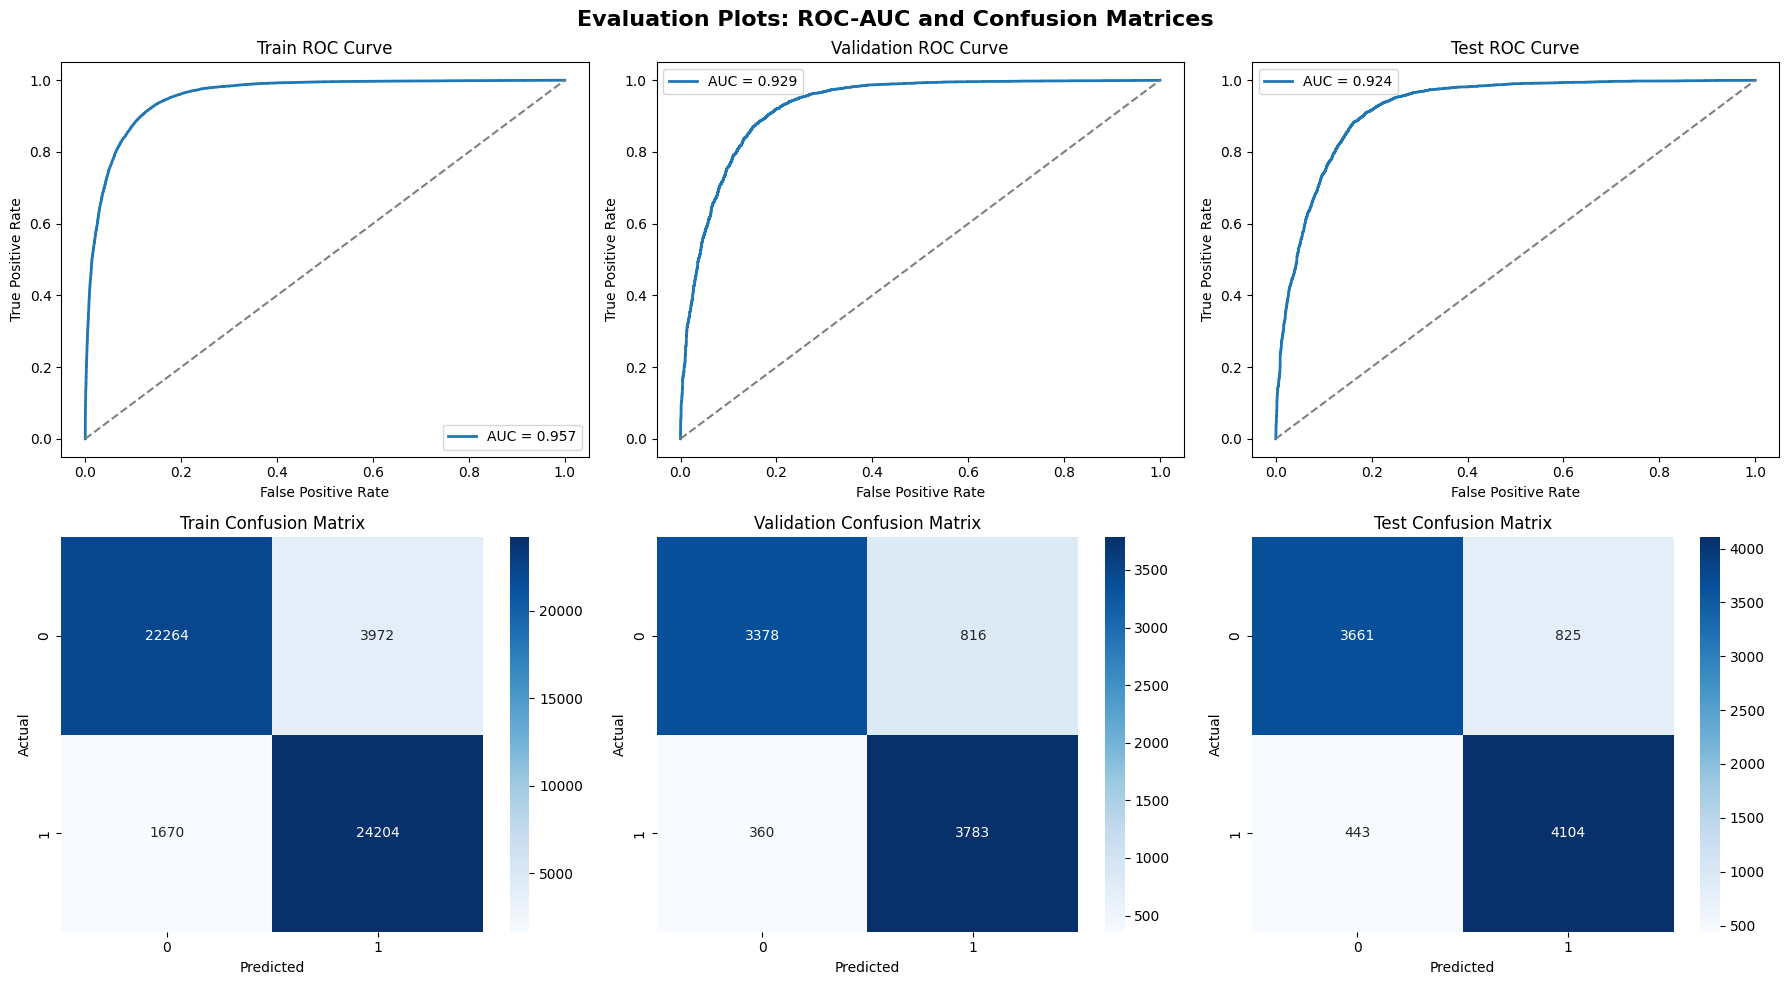

In [18]:
# Evaluation function
model_logistic , results_df, y_pred_train, y_pred_val, y_pred_test = evaluate_with_threshold(
    model=train_model(LogisticRegression(max_iter=3000), X_train, y_train),
    X_train=X_train, y_train=y_train,
    X_val=X_valid, y_val=y_valid,
    X_test=X_test, y_test=y_test,
    threshold=0.5,
    save_csv=True
)

print("\n Logistic Regression Results:")
display(results_df)

# Plots
plot_eval_charts(
    model=model_logistic,
    X_train=X_train, y_train=y_train,
    X_val=X_valid, y_val=y_valid,
    X_test=X_test, y_test=y_test,
    threshold=0.5
)


Results saved to nb_results.csv

 Naive Bayes Results:


,train_accuracy,train_precision,train_recall,train_f1,train_auc,val_accuracy,val_precision,val_recall,val_f1,val_auc,test_accuracy,test_precision,test_recall,test_f1,test_auc
0,0.876243,0.836713,0.93279,0.882143,0.949331,0.852465,0.810092,0.918417,0.86086,0.923523,0.84778,0.809162,0.91291,0.857911,0.918588


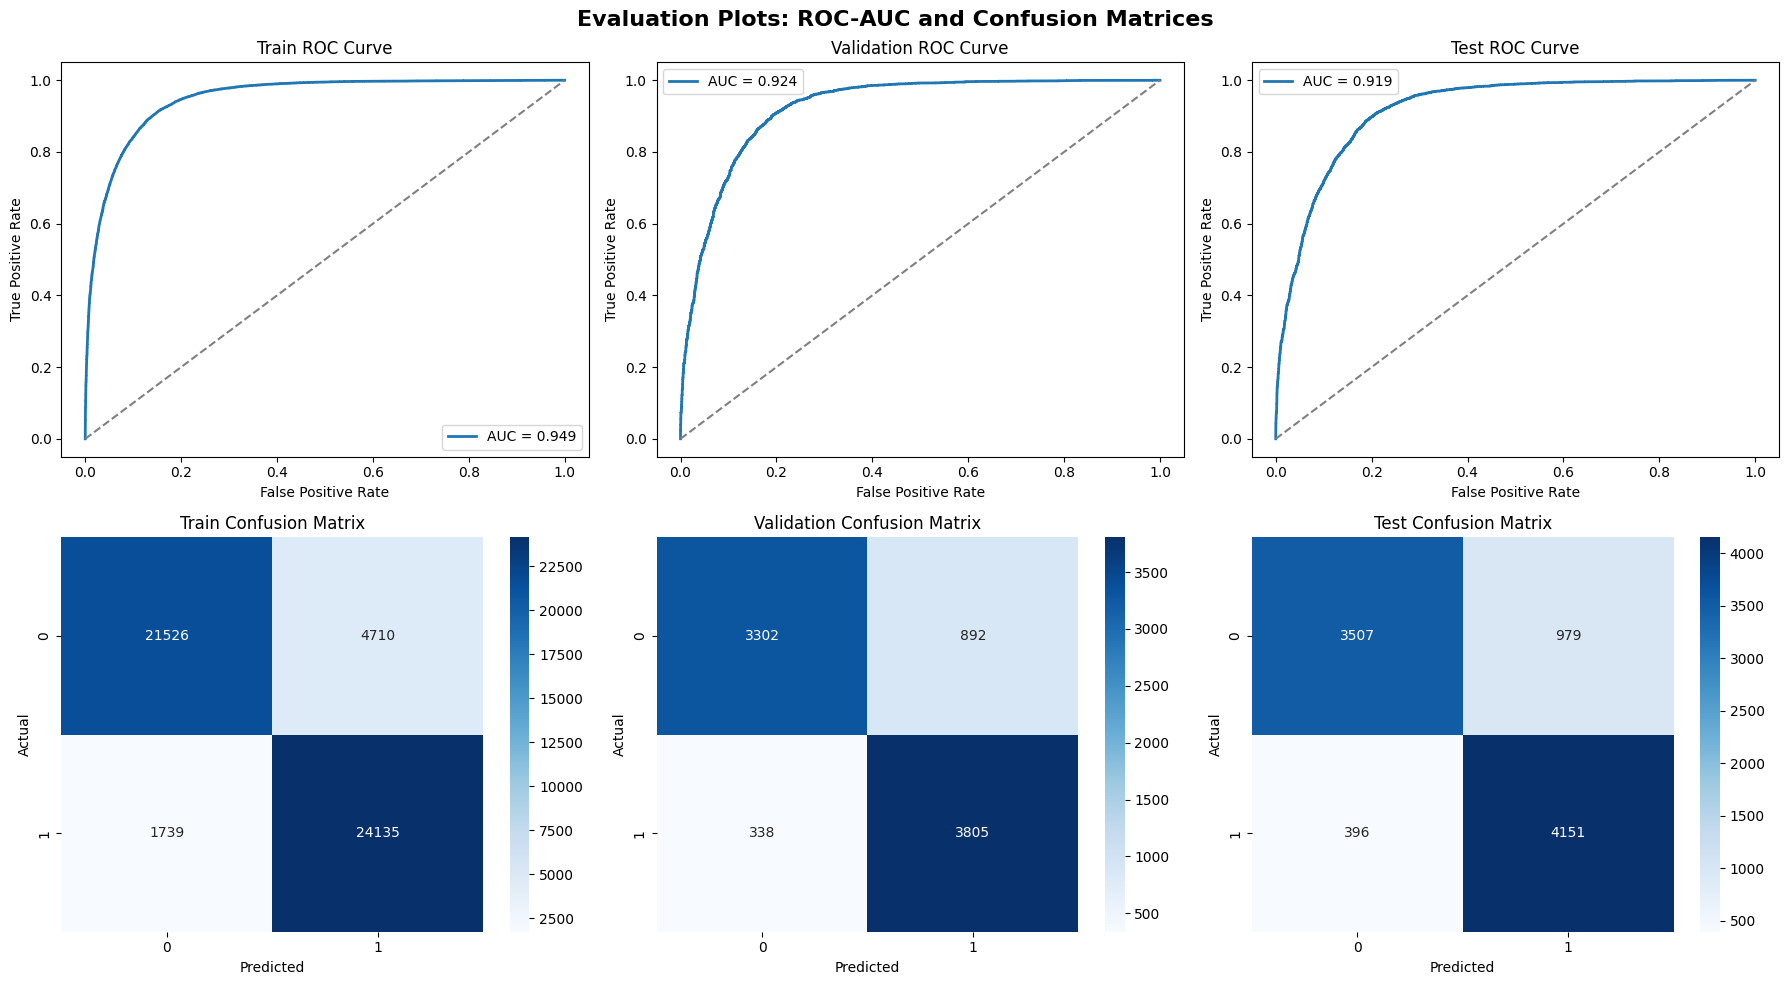

In [19]:
model_nb , results_nb, _, _, _ = evaluate_with_threshold(
    model=train_model(MultinomialNB(), X_train, y_train),
    X_train=X_train, y_train=y_train,
    X_val=X_valid, y_val=y_valid,
    X_test=X_test, y_test=y_test,
    threshold=0.5,
    save_csv=True,
    filename="nb_results.csv"
)

print("\n Naive Bayes Results:")
display(results_nb)

plot_eval_charts(
    model=model_nb,
    X_train=X_train, y_train=y_train,
    X_val=X_valid, y_val=y_valid,
    X_test=X_test, y_test=y_test,
    threshold=0.5
)


In [20]:
def save_models(model_logistic, model_nb, vectorizer, folder="models"):

    # Create folder if not exists
    if not os.path.exists(folder):
        os.makedirs(folder)
        print("Folder created:", folder)

    # Save each file
    joblib.dump(model_logistic, f"{folder}/model_logistic.pkl")
    joblib.dump(model_nb, f"{folder}/model_nb.pkl")
    joblib.dump(vectorizer, f"{folder}/vectorizer.pkl")

    print("Models and vectorizer saved successfully!")


save_models(model_logistic, model_nb, vectorizer)


Models and vectorizer saved successfully!


In [21]:
def predict_sentiment(model, text, threshold=0.5):
    # preprocess input text
    cleaned = preprocess(text)

    # vectorize
    vec = vectorizer.transform([cleaned])

    # get probability of class 1 (positive)
    prob = model.predict_proba(vec)[0][1]   # index 1 → positive class

    # apply threshold
    label = 1 if prob > threshold else 0

    # readable output
    sentiment = " منفی" if label == 1 else " مثبت"

    print(f"🔍 جمله ورودی: {text}")
    print(f"📌 احتمال منفی بودن: {prob*100:.1f}")
    print(f"🏷️ نتیجه مدل: {sentiment}")

    return sentiment, prob

In [22]:
texts = ["افتضاح بود، خیلی دیر رسید و کیفیتش هم اصلا خوب نبود." , "غذا عالی بود، خیلی خوشمزه و سریع رسید، واقعا راضی‌ام.", "طعمش خوب بود ولی زمان تحویل خیلی طول کشید.", "خیلی خوب بود 😍🔥 دوباره سفارش می‌دم.", "اصلاً ارزش پول نداشت، فاجعه، دیگه هیچوقت سفارش نمی‌دم.",     "غذا خوب بود ولی خیلی دیر آوردن و سرد شده بود."]
for text in texts:
    predict_sentiment(model_nb , text)
    print('\n')

🔍 جمله ورودی: افتضاح بود، خیلی دیر رسید و کیفیتش هم اصلا خوب نبود.
📌 احتمال منفی بودن: 91.5
🏷️ نتیجه مدل:  منفی


🔍 جمله ورودی: غذا عالی بود، خیلی خوشمزه و سریع رسید، واقعا راضی‌ام.
📌 احتمال منفی بودن: 0.1
🏷️ نتیجه مدل:  مثبت


🔍 جمله ورودی: طعمش خوب بود ولی زمان تحویل خیلی طول کشید.
📌 احتمال منفی بودن: 30.8
🏷️ نتیجه مدل:  مثبت


🔍 جمله ورودی: خیلی خوب بود 😍🔥 دوباره سفارش می‌دم.
📌 احتمال منفی بودن: 21.8
🏷️ نتیجه مدل:  مثبت


🔍 جمله ورودی: اصلاً ارزش پول نداشت، فاجعه، دیگه هیچوقت سفارش نمی‌دم.
📌 احتمال منفی بودن: 98.0
🏷️ نتیجه مدل:  منفی


🔍 جمله ورودی: غذا خوب بود ولی خیلی دیر آوردن و سرد شده بود.
📌 احتمال منفی بودن: 37.7
🏷️ نتیجه مدل:  مثبت




In [23]:
for text in texts:
    predict_sentiment(model_logistic , text)
    print('\n')

🔍 جمله ورودی: افتضاح بود، خیلی دیر رسید و کیفیتش هم اصلا خوب نبود.
📌 احتمال منفی بودن: 95.2
🏷️ نتیجه مدل:  منفی


🔍 جمله ورودی: غذا عالی بود، خیلی خوشمزه و سریع رسید، واقعا راضی‌ام.
📌 احتمال منفی بودن: 0.1
🏷️ نتیجه مدل:  مثبت


🔍 جمله ورودی: طعمش خوب بود ولی زمان تحویل خیلی طول کشید.
📌 احتمال منفی بودن: 15.0
🏷️ نتیجه مدل:  مثبت


🔍 جمله ورودی: خیلی خوب بود 😍🔥 دوباره سفارش می‌دم.
📌 احتمال منفی بودن: 2.5
🏷️ نتیجه مدل:  مثبت


🔍 جمله ورودی: اصلاً ارزش پول نداشت، فاجعه، دیگه هیچوقت سفارش نمی‌دم.
📌 احتمال منفی بودن: 97.5
🏷️ نتیجه مدل:  منفی


🔍 جمله ورودی: غذا خوب بود ولی خیلی دیر آوردن و سرد شده بود.
📌 احتمال منفی بودن: 25.0
🏷️ نتیجه مدل:  مثبت


